# **TAREA 1a: Graph Neural Networks (Teoría y ejemplos)**

En esta tarea trataremos la aplicación de redes neuronales en grafos. Las Graph Neural Networks (GNNs) han crecido en popularidad tanto en aplicaciones como en investigación, incluyendo campos como redes sociales, knowledge graphs, sistemas de recomendación y bioinformática. Aunque la teoría y las matemáticas que subyacen a las GNN pueden parecer complicadas en un principio, la implementación de estos modelos es bastante sencilla y ayuda a comprender la metodología. Por lo tanto, analizaremos la implementación de las capas básicas de una GNN, que son las graph convolutions y las attention layers. Por último, aplicaremos una GNN a tareas a nivel de nodo, de arista y de grafo.


In [3]:
## Librerias
import os
import json
import math
import numpy as np
import time

## Imports gráficos
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # Para exportarlo
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Barra de progreso
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10 #dataset de imágenes de 10 clases diferentes
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path donde cargar/guardar los datasets
DATASET_PATH = "../data"
# Path donde guardar los modelos pre-entrenados
CHECKPOINT_PATH = "../saved_models/tarea1"

# Semilla
pl.seed_everything(42)

# Poner las operaciones deterministicas en la GPU para poder reproducirlas
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Configuración de dispositivo 
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

/var/folders/4h/bg12rs4d7n3c6p64vwtqhqqh0000gn/T/ipykernel_14842/3732865111.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # Para exportarlo
Global seed set to 42


cpu


Antes de seguir, se deben incluir en la carpeta "tarea1" los tres ficheros siguientes: "NodeLevelMLP.ckpt", "NodeLevelGNN.ckpt" y "GraphLevelGraphConv.ckpt"




## Un poquito de teoría de Graph Neural Networks

### ¿Cómo representar un grafo?

Antes de nada, vamos a definir como se representa un grafo. Matemáticamente, un grafo $\mathcal{G}$ se define como una tupla de un conjunto de nodos $V$, y un conjunto de aristas $E$: $\mathcal{G}=(V,E)$. Cada arista se representa como un par de valores (nodos), y representan una conexión entre ellos.
Los aristas pueden tener pesos o no (weighted o unweighted) y tener dirección o no (directed o undirected).

Por ejemplo:

<center width="100%" style="padding:10px"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/example_graph.svg" width="250px"></center>

Los nodos son $V=\{1,2,3,4\}$, y las aristas $E=\{(1,2), (2,3), (3,4), (2,4)\}$. Por simplicidad, es unweighted y undirected, y deberían incluirse los pares simétricos (por ejemplo, el $(2,1)$). Normalmente, para las aristas, se usa para representar los valores y operar con ellas la matriz de adyacencia o la lista de pares de nodos .

La **Matriz de Adyacencia** $A$ es una matriz cuadrada cuyos elementos indican todos los pares denodos que son adyacentes, es decir, conectados o no. En el caso más simple, $A_{ij}$ = 1 si hay conexión entre los nodos $i$ y $j$, y 0 en el caso de que no haya conexión. Si los aristas tuviesen peso, ese valor sustituiría a los unos. Un grafo no dirigido es simétrico, y por lo tanto ($A_{ij}=A_{ji}$). Para el ejemplo, tenemos la matriz de adyacencia siguiente:

$$
A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}
$$

En esta tarea usaremos la matriz de adyacencia para que se vea más simple y claro visualmente, pero en terminos de eficiencia de memoria es mejor las listas de aristas (y las librerías suelen implementarlas más).
Se puede pasar de listas a matrices dispersas (sparse), haciendolo eficiente, mediante el subpaquete`torch.sparse` ([documentación](https://pytorch.org/docs/stable/sparse.html)).

### Convoluciones de grafos (Graph Convolutions, GCNs)

Las GCNs, introducidas por [Kipf et al.](https://openreview.net/pdf?id=SJU4ayYgl) in 2016 [blog](https://tkipf.github.io/graph-convolutional-networks/), son parecidas a las convoluciones en imágenes en el sentido de filtrado de parámetros compartido en diferentes localizaciones del grafo. Al mismo tiempo, se basan en métodos de paso de mensajes, lo que significa que los nodos intercambian información con los vecinos y se envían "mensajes" entre sí. Antes de ver la notación matemática, podemos intentar comprender visualmente cómo funcionan las GCN.
En un primer paso, cada nodo crea un vector de características que representa el mensaje que quiere enviar a todos sus vecinos. En el segundo paso, los mensajes se envían a los vecinos, de forma que un nodo recibe un mensaje por nodo adyacente o vecino. A continuación se muestran ambos pasos con el ejemplo anterior :

<center width="100%" style="padding:10px"><img src="https://miro.medium.com/v2/resize:fit:1246/0*zhmuVMqj8pgvJI3O" width="700px"></center>

Si queremos formularlo en términos más matemáticos, primero tenemos que decidir cómo combinar todos los mensajes que recibe un nodo. Como el número de mensajes varía de un nodo a otro, necesitamos una operación que funcione para cualquier número. Por eso, lo habitual es la suma o la media. Dadas las características anteriores de los nodos $H^{(l)}$, la capa GCN se define como:

$$H^{(l+1)} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)}\right)$$

$W^{(l)}$ son los pesos de los parámetros con los que transformamos las características de entrada en mensajes ($H^{(l)}W^{(l)}$). A la matriz de adyacencia $A$ le añadimos la matriz identidad para que cada nodo se envíe su propio mensaje también a sí mismo, representándolo así: $\hat{A}=A+I$. Por último, para sacar la media en este caso, calculamos la matriz $\hat{D}$ que es una matriz diagonal donde $D_{ii}$ contiene el número de vecinos que tiene el nodo $i$. Por último, $\sigma$ representa una función de activación arbitraria, y no necesariamente la sigmoidea (normalmente en las GNNs se utiliza una función de activación basada en ReLU).

Al implementar la capa GCN en PyTorch, podemos aprovechar la flexibilidad de las operaciones sobre tensores. En lugar de definir una matriz $\hat{D}$, podemos simplemente dividir los mensajes sumados por el número de vecinos después. Además, sustituimos la matriz de pesos por una capa lineal, que adicionalmente nos permite añadir un sesgo.
El código de la capa GCN se debe definir de la siguiente forma:

In [4]:
class GCNLayer(nn.Module):

    #Entradas 
    #c_in: Número de características (channels) de entrada.
    #c_out: Número de características (channels) de salida.
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)


    #Esta función realiza la propagación hacia adelante (forward pass) de la capa GCN.
    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor con las características del nodo con formato [batch_size, num_nodes, c_in].
            adj_matrix - Matriz de adyacencia del grafo. Si hay una arista del nodo i al j, adj_matrix[b,i,j]=1 sino 0.
                         También admite grafos dirigidos, asumiendo que ya llevan la matriz identidad sumada en batch_size: [batch_size, num_nodes, num_nodes]
        """
        #Numero de vecinos (num_neighbours), en este caso, se refiere a los vecinos de entrada (in) en grafos dirigidos
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        #Proyecta las características de los nodos de c_in a c_out 
        node_feats = self.projection(node_feats)
        #Realiza una multiplicación de matrices en batch entre la matriz de adyacencia y las características de los nodos proyectadas. Esto efectivamente suma las características de los vecinos de cada nodo.
        node_feats = torch.bmm(adj_matrix, node_feats)
        #Normalización de las caracteristicas 
        node_feats = node_feats / num_neighbours
        return node_feats

Para comprender mejor la capa GCN, lo podemos aplicar a nuestro grafo de ejemplo anterior. En primer lugar, especifiquemos algunas características de los nodos y la matriz de adyacencia con autoconexiones añadidas (self-loops):

In [5]:
#Crea un tensor unidimensional con valores [0., 1., 2., 3., 4., 5., 6., 7.] de tipo float32.
# .view(1, 4, 2): Cambia la forma (shape) del tensor a un tensor tridimensional. El tensor resultante tiene una forma de [1, 4, 2], lo que significa 1 batch, 4 nodos, y 2 características por nodo.
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)

# Creando un tensor tridimensional que representa una matriz de adyacencia para un grafo dirigido con 4 nodos
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Características de los nodos:\n", node_feats)
print("\Matriz de adyacencia:\n", adj_matrix)

Características de los nodos:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
\Matriz de adyacencia:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


A continuación, vamos a aplicarle una capa GCN. Para simplificar, inicializamos la matriz de pesos lineal como una matriz de identidad para que las características de entrada sean iguales a los mensajes. Esto nos facilita la verificación de la operación de paso de mensajes.

In [6]:
# Creamos una capa 2 características de entrada y 2 de salida.
layer = GCNLayer(c_in=2, c_out=2)

# Configurando manualmente los pesos y el sesgo de la capa lineal, no cambiará las características de entrada.
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

# Aplicación de la capa
with torch.no_grad(): #Dentro de este bloque de código incluimos todo lo que queremos ejecutar sin cálculo de gradientes para no hacer backpropagation
    out_feats = layer(node_feats, adj_matrix)

print("Matriz de adyacencia", adj_matrix)
print("Características de entrada", node_feats)
print("Características de salida", out_feats)

Matriz de adyacencia tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Características de entrada tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Características de salida tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


Como podemos ver, los valores de salida del primer nodo son la media de sí mismo y del segundo nodo. Del mismo modo, podemos verificar todos los demás nodos. Sin embargo, en una GNN, también querríamos permitir el intercambio de características entre nodos más allá de sus vecinos. Esto se puede conseguir aplicando múltiples capas GCN, lo que nos da la disposición final de una GNN. La GNN puede construirse mediante una secuencia de capas GCN y no lineales como ReLU. Se puede ver en la imagen.

<center width="100%" style="padding: 10px"><img src="https://theaisummer.com/static/cb743cf6762bf14d48c1548bf0f0fe1f/9a128/gnn.jpg" width="600px"></center>

Sin embargo, un problema que podemos ver al observar el ejemplo anterior es que las características de salida de los nodos 3 y 4 son las mismas porque tienen los mismos nodos adyacentes (incluido él mismo). Por lo tanto, las capas GCN pueden hacer que la red olvide la información específica de cada nodo si sólo tomamos la media de todos los mensajes. Se han propuesto muchas mejoras posibles. Mientras que la opción más sencilla podría ser utilizar conexiones residuales, el enfoque más común es ponderar más las autoconexiones o definir una matriz de pesos separada para las autoconexiones. Alternativamente, podemos tratarlo con Graph Attention.

### Graph Attention

Antes de nada, tenemos que explicar **¿Qué es la atención?** Se trata de un mecanismo de capas de redes neuronales basada en secuenciación. Se puede definir como una media ponderada de elementos de secuencia con los pesos calculados de forma dinámica en función de una consulta de entrada y elementos clave.
El objetivo es hacer una media de las características de varios elementos. Sin embargo, en lugar de ponderar cada elemento por igual, queremos ponderarlos en función de sus valores reales. En otras palabras, queremos decidir dinámicamente a qué entradas queremos "prestar más atención" que a otras. Se organiza en cuatro partes:


*   Consulta (query):  vector de características que describe lo que estamos buscando en la secuencia, es decir, a qué querríamos prestar atención.
*   Claves (keys): para cada elemento de entrada, tenemos una clave que, de nuevo, es un vector de características. Este vector de características describe a grandes rasgos lo que el elemento "ofrece", o cuándo puede ser importante. Las claves deben diseñarse de forma que podamos identificar los elementos a los que queremos prestar atención basándonos en la consulta.
*   Valores (values): para cada elemento de entrada, también tenemos un vector de valores. Este vector de características es el que queremos promediar.
*   Función de puntuación (score function): para calificar los elementos a los que queremos prestar atención, necesitamos especificar una función de puntuación, la cual toma como entrada la consulta y una clave, y da como salida la puntuación/peso de atención del par consulta-clave. Suele implementarse mediante métricas de similitud sencillas.

Los pesos de la media se calculan mediante un softmax sobre todas las salidas de la función de puntuación. Por lo tanto, asignamos un peso mayor a aquellos vectores de valores cuya clave correspondiente es más similar a la consulta.


**¿Y si aplicamos este concepto a los grafos? ** Puede aplicarse de forma similar a los grafos, con las Graph Attention Network (GAT). De forma similar a la GCN, la capa de atención de grafos crea un mensaje para cada nodo utilizando una matriz lineal de capa/peso. Para la parte de atención, utiliza el mensaje del propio nodo como consulta, y los mensajes a promediar como claves y valores (nótese que esto también incluye el mensaje a sí mismo). La función de puntuación $f_{atcn}$ se implementa como un Multi-Layer Perceptron (MLP) de una capa que asigna la consulta y la clave a un único valor. El MLP tiene el siguiente aspecto:


<center width="100%" style="padding:10px"><img src="https://pctg.net/wp-content/uploads/2023/07/1688971037_411_Todo-lo-que-necesitas-saber-sobre-Graph-Attention-Networks.png" width="250px"></center>

Entremos con un poco de notación matemática:

$h_i$ y $h_j$ son las característias originales de los nodos $i$ y $j$ respectivamente, y representa los mensajes de la capa con $\mathbf{W}$ como matriz de pesos. $\mathbf{a}$ es la matriz de pesos de la MLP, la cual tiene la forma $[1,2\times d_{\text{msg}}]$, y $\alpha_{ij}$ el peso de atención final desde el nodo $i$ al $j$. El cálculo puede ser descrito mediante la siguiente fórmula:

$$\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)\right)}$$

El operador $||$ representa la concatenación, y $\mathcal{N}_i$ los índices de los vecinos del nodo $i$. Nótese que, a diferencia de la práctica habitual, aplicamos una no linealidad (LeakyReLU) antes del softmax sobre los elementos.Aunque a primera vista parece un cambio menor, es crucial para que la atención dependa de la entrada original. Vamos a eliminar la no linealidad por un momento, y tratar de simplificar la expresión:

$$
\begin{split}
    \alpha_{ij} & = \frac{\exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\
\end{split}
$$


Podemos ver que sin la no linealidad, el término de atención con $h_i$ en realidad se anula a sí mismo, por lo que la atención es independiente del propio nodo. Por lo tanto, tendríamos el mismo problema que el GCN de crear las mismas características de salida para los nodos con los mismos vecinos. Por eso el LeakyReLU es crucial y añade cierta dependencia de $h_i$ a la atención.

Una vez que obtenemos todos los factores de atención, podemos calcular las características de salida para cada nodo realizando la media ponderada:

$$h_i'=\sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}h_j\right)$$

$\sigma$ es aún no lineal, como una capa GCN. Visualmente, podríamos representar el paso completo del mensaje en una capa de atención.

<center width="100%"><img src="https://mila.quebec/wp-content/uploads/2018/07/687474703a2f2f7777772e636c2e63616d2e61632e756b2f25374570763237332f696d616765732f6761742e6a7067-1024x669.jpeg" width="400px"></center>

Para aumentar la expresividad de la red de atención gráfica propusieron ampliarla a múltiples cabezas, con $N$ capas de atención que se aplican en paralelo. En la imagen de arriba, se visualiza como tres colores diferentes de flechas (verde, azul y morado) se concatenan. La media sólo se aplica a la última capa de predicción de una red.

Un ejemplo de implementación sería:

In [7]:
class GATLayer(nn.Module):
    #c_in: Número de características de entrada.
    #c_out: Número de características de salida.
    #num_heads: Número de "cabezas" de atención. Cada "cabeza" aprende diferentes pesos de atención y, por lo tanto, puede atender a diferentes partes de la información de entrada.
    #concat_heads: Si es True, concatena las salidas de las diferentes cabezas.
    #alpha: Pendiente negativa de la activación LeakyReLU.
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionalidad de las características de entrada
            c_out - Dimensionalidad de las características de salida
            num_heads - Número de heads (para trabajar en paralelo). Las características de salida se reparten equitativamente por cada head si concat_heads=True.
            concat_heads - Si es True, la salida de cada head se concatena en lugar de promediarse.
            alpha - Pendiente negativa de la activación LeakyReLU.
        """
        super().__init__() #Inicializamos
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "El número de características de salida debe ser múltiplo del número de heads."
            c_out = c_out // num_heads

        # Sub-modulos y parámetros necesarios en la capa
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # Uno por head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Inicialización de la implementación original
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Características de entrada del nodo. Formato: [batch_size, c_in]
            adj_matrix - Matriz de adyacencia con self-loops. Formato: [batch_size, num_nodes, num_nodes]
            print_attn_probs - Si es True, los pesos de atención se muestran durante el paso forward (debugging)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1) #Se extraen datos del tensor de entrada

        # Applicamos una capa lineal y ordenamos los nodos por head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # Tenemos que calcular los "attention logits" (valores de la capa de salida, previa a la función de activación) para cada arista de la matriz de adyacencia
        # Se trata de algo muy costoso, puesto que hay que hacerlo para toda combinación posible
        # Solución => Creamos un tensor [W*h_i||W*h_j] con i y j como índices de todas las aristas
        edges = adj_matrix.nonzero(as_tuple=False) # Obtenemos los índices donde la matriz de adyacencia no es 0 (existencia de arista)
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Devuelve un tensor con node_feats_flat con las posiciones indexadas en dim=0

        # Calculamos la salida de atención de la MLP (independiente para cada head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Se mapea la lista de valores de atención a una matriz de nuevo
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)

        # Se calcula la media de pesos de atención
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Probabilidades de atención\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # Si se desean concatenar los head, se hace un reshaping. En caso contrario tomamos la media
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

Una vez más, podemos aplicar la capa graph attention en nuestro grafo de ejemplo anterior para entender mejor la dinámica. Al igual que antes, la capa de entrada se inicializa como una matriz de identidad, pero ponemos $\mathbf{a}$ como vector de números arbitrarios para obtener diferentes valores de atención. Utilizamos dos head para mostrar los mecanismos de atención, paralelos e independientes, que trabajan en la capa.

In [8]:
layer = GATLayer(2, 2, num_heads=2) #Dos dimensiones de entrada y salida, y dos head
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]]) #Los pesos es la matriz de identidad
layer.projection.bias.data = torch.Tensor([0., 0.]) #Sin sesgo
layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]]) #Datos de ejemplo

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True)

print("Matriz de Adyacencia", adj_matrix)
print("Características de entrada", node_feats)
print("Características de salida", out_feats)

Probabilidades de atención
 tensor([[[[0.3543, 0.6457, 0.0000, 0.0000],
          [0.1096, 0.1450, 0.2642, 0.4813],
          [0.0000, 0.1858, 0.2885, 0.5257],
          [0.0000, 0.2391, 0.2696, 0.4913]],

         [[0.5100, 0.4900, 0.0000, 0.0000],
          [0.2975, 0.2436, 0.2340, 0.2249],
          [0.0000, 0.3838, 0.3142, 0.3019],
          [0.0000, 0.4018, 0.3289, 0.2693]]]])
Matriz de Adyacencia tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Características de entrada tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Características de salida tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


Recomendación: intentar calcular la matriz de atención al menos para una cabeza y un nodo por sí mismo. Las entradas son 0 cuando no existe ninguna arista entre $i$ y $j$. Para los demás, vemos un conjunto diverso de probabilidades de atención. Además, las características de salida de los nodos 3 y 4 son ahora diferentes aunque tengan los mismos vecinos.

## PyTorch Geometric (Grandes grafos)

Hemos probado con grafos de ejemplo, pero...**¿Qué ocurre con grafos del mundo real?** Ya hemos mencionado antes que la implementación de grafos con matrices de adyacencia es sencilla y directa, pero puede resultar costosa desde el punto de vista computacional para grafos de gran tamaño. Muchos grafos del mundo real pueden llegar a tener más de cientos de miles o millones nodos (por ejemplo, una red social), por lo que las implementaciones basadas en matrices de adyacencia fallan. Hay muchas optimizaciones posibles al implementar GNNs, y por suerte, existen paquetes que proporcionan dichas capas. Los paquetes más populares para PyTorch son [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) y [Deep Graph Library](https://www.dgl.ai/) (esta última no está específicamente diseñado para funcionar con un framework o entorno de desarrollo particular). Cuál usar depende del proyecto que estemos planeando hacer. Lo primero que vamos a hacer es instalarlo (PyTorch Geometric no está instalado por defecto en GoogleColab):

In [9]:
# torch geometric
try:
    import torch_geometric
except ModuleNotFoundError:
    # Instalar paquetes torch geometriccon una versión específica de CUDA+PyTorch.
    # Más detalles en https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric
    import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

PyTorch Geometric nos proporciona un conjunto de capas de grafos comunes, incluyendo las capas GCN y GAT implementadas antes. Además, de forma similar a torchvision de PyTorch, proporciona los conjuntos de datos de grafos comunes y las transformaciones en ellos para simplificar el entrenamiento. En comparación con nuestra implementación anterior, PyTorch Geometric utiliza una lista de pares de índices para representar las aristas. Los detalles de esta biblioteca se explorarán más a fondo en nuestros experimentos.

En nuestras tareas a continuación, queremos que nos permita elegir entre una multitud de capas de grafos. Por lo tanto, definimos de nuevo a continuación un diccionario para acceder usando strings:

In [10]:
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv
}

Además de las GCN y GAT explicadas, hemos includo la capa `geom_nn.GraphConv` ([documentación](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv)). GraphConv es un GCN con una matriz de pesos separada para las autoconexiones. Matemáticamente sería así:

$$
\mathbf{x}_i^{(l+1)} = \mathbf{W}^{(l + 1)}_1 \mathbf{x}_i^{(l)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{j \in \mathcal{N}_i} \mathbf{x}_j^{(l)}
$$

En esta fórmula, los mensajes de los vecinos se suman en lugar de promediarse. Sin embargo, PyTorch Geometric proporciona el argumento `aggr` para cambiar entre sumar, promediar y max pooling.

# **TAREA 1b: Graph Neural Networks (Práctica)**

## Experimentos con datos estructurados en grafos

Las tareas sobre datos estructurados en grafos pueden agruparse en tres grupos: a nivel de nodo, a nivel de arista y a nivel de grafo. Los distintos niveles describen en qué nivel queremos realizar la clasificación/regresión. A continuación analizaremos los tres tipos con ejemplos concretos, con más detalle.

### A nivel de nodo (Node-level tasks). Ejemplo: clasificación semisupervisada de publicaciones científicas.


Las tareas a nivel de nodo tienen como objetivo clasificar los nodos de un grafo. Normalmente, tenemos un único grafo de gran tamaño con más de 1.000 nodos, de los cuales una cierta cantidad están etiquetados. Aprendemos a clasificar esos ejemplos etiquetados durante el entrenamiento e intentamos generalizar a los nodos no etiquetados.

Un ejemplo típico es el dataset  [Cora](https://relational.fit.cvut.cz/dataset/CORA), que se trata de una red de citas entre artículos científicos. Cora consta de 2708 publicaciones científicas con 5429 enlaces entre sí que representan la citación de un artículo por otro. La tarea consiste en clasificar cada publicación en una de las siete clases o categorías (Case_Based, Genetic_Algorithms, Neural_Networks, Probabilistic_Methods, Reinforcement_Learning, Rule_Learning y Theory).

<center width="100%" style="padding:10px"><img src="https://production-media.paperswithcode.com/datasets/Cora-0000000700-ce1c5ec7_LD7pZnT.jpg" width="350px"></center>


Cada publicación está representada por un vector bag-of-words. Esto significa que tenemos un vector de 1433 elementos para cada publicación, donde un 1 en la característica $i$ indica que la $i$-ésima palabra de un diccionario predefinido está en el artículo. Las representaciones binarias de bag-of-words se suelen utilizar cuando necesitamos codificaciones muy sencillas y ya tenemos una intuición de qué palabras esperar en una red. Existen otros enfoques mejores, que se verán más adelante.

A continuación cargaremos el conjunto de datos:

In [11]:
cora_dataset = torch_geometric.datasets.Planetoid(root=DATASET_PATH, name="Cora")

Vamos a ver cómo PyTorch Geometric representa los datos de grafo. Hay que tener en cuenta que, a pesar de que tenemos un solo grafo, PyTorch Geometric devuelve un conjunto de datos para la compatible con otros datasets.

In [12]:
data = cora_dataset[0]
data # x es una matriz de características con formato [num_nodes, num_node_features]
#data.is_directed()
print(data)
data.num_edges # ¿Por qué sale este número de aristas?

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


10556

El grafo está representado por un objeto `Data` ([documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data)) al que podemos acceder como un namespace estándar de Python. El tensor de índices de aristas es la lista de aristas del grafo y contiene la versión simétrica de cada arista para grafos no dirigidos. Las máscaras `train_mask`, `val_mask` y `test_mask` son máscaras booleanas que indican qué nodos debemos utilizar para el entrenamiento, la validación y la prueba. El tensor `x` es el tensor de características de nuestras 2708 publicaciones, y `y` las etiquetas de todos los nodos.

Una vez vistos los datos, podemos implementar una red neuronal de grafos sencilla. La GNN aplica una secuencia de capas de grafos (GCN, GAT o GraphConv), ReLU como función de activación y dropout para la regularización. Vamos a ver la implementación específica:

In [13]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Entradas:
            c_in - Dimensionalidad de las características de entrada
            c_hidden - Dimensionalidad de las características de la oculta
            c_out - Dimensionalidad de las características de salida. Normalmente corresponde con el número de clases de la clasificación
            num_layers - Número de capas ocultas
            layer_name - Nombre de técnica a usar
            dp_rate - La "tasa de dropout" (dropout rate) de la red (hiperparámetro para regularizar y mejorar el rendimiento, reduciendo así el riesgo de overfitting)
            kwargs - Argumentos adicionales (por ejemplo, el número de heads su usamos una GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Entradas:
            x - Características de entrada para cada nodo
            edge_index - Lista de índices de aristas del grafo (notación de PyTorch geometric)
        """
        for l in self.layers:
            # Para las capas, necesitamos añadir el tensor "edge_index" como entrada adicional
            # Toda capa PyTorch Geometric graph hereda la clase "MessagePassing", por lo tanto, podemos comprobar el tipo de clase de forma sencilla
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

Una buena práctica en las tareas a nivel de nodo consiste en crear una MLP baseline que se aplique a cada nodo de forma independiente. De esta forma podemos comprobar si la suma de la información del grafo al modelo mejora realmente la predicción, o no. También puede ocurrir que las características por nodo ya sean lo suficientemente expresivas como para apuntar claramente hacia una clase específica. Para comprobarlo, a continuación implementamos un MLP sencillo:

In [14]:
class MLPModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """
        Entradas:
            c_in - Dimensionalidad de las características de entrada
            c_hidden - Dimensionalidad de las características de la oculta
            c_out - Dimensionalidad de las características de salida. Normalmente corresponde con el número de clases de la clasificación
            num_layers - Número de capas ocultas
            dp_rate - La "tasa de dropout" de la red
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1): #Aplicamos linealidad, funcion de activación RELU y dropout para el overfitting
            layers += [
                nn.Linear(in_channels, out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """
        Entradas:
            x - Características de entrada por nodo
        """
        return self.layers(x)

Por último, podemos fusionar los modelos en un módulo PyTorch Lightning que se encargue del entrenamiento, la validación y las pruebas por nosotros.

In [15]:
class NodeLevelGNN(pl.LightningModule):

    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Guardar los hiperparámetros
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Solo se calcula la pérdida en los nodos que corresponden a la máscara
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, f"Modo desconocido: {mode}"

        loss = self.loss_module(x[mask], data.y[mask]) #Pérdida
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum() #Eficiencia (accuracy)
        return loss, acc

    def configure_optimizers(self):
        # Usamos Stochastic Gradient Descent (SGD) como algoritmo de optimización, pero Adam también es una buena opción
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)

Además del módulo Lightning, definimos una función de entrenamiento. Como tenemos un grafo simple, utilizamos un tamaño de lote (batch_size) de 1 para cargar datos y compartimos el mismo para el conjunto de entrenamiento, validación y prueba (la máscara se elige dentro del módulo Lightning). Además, establecemos el argumento `enable_progress_bar` a False (sirve para mostrar una barra de progreso con el progreso del entrenamiento a medida que se ejecutan las épocas, pero en este caso al tener tamaño uno carece de sentido, y se muestra solo al final).

In [16]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    pl.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1) #loader.DataLoader

    # Creamos un PyTorch Lightning trainer (entrenamiento) con llamada de retorno (generation callback)
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=200,
                         enable_progress_bar=False) # False porque el tamaño de la época es 1
    trainer.logger._default_hp_metric = None # No es necesario un argumento para el logging

    # Comprobamos que el modelo preentrenado existe, cargándolo y saltando el paso de entrenamiento en caso afirmativo
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"NodeLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Se ha encontrado un modelo preentrenado, cargando...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything()
        model = NodeLevelGNN(model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs)
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Probamos el mejor modelo en el conjunto de test
    test_result = trainer.test(model, node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc,
              "val": val_acc,
              "test": test_result[0]['test_acc']}
    return model, result

Por último, podemos entrenar nuestros modelos. En primer lugar, vamos a entrenar el MLP simple:

In [17]:
#Función para mostrar los resultados
def print_results(result_dict):
    print(f"\nAccuracy:\n")
    if "train" in result_dict:
        print(f"Entrenamiento: {(100.0*result_dict['train']):4.2f}%")
    if "val" in result_dict:
        print(f"Validación:   {(100.0*result_dict['val']):4.2f}%")
    print(f"Test:  {(100.0*result_dict['test']):4.2f}%")

In [18]:
node_mlp_model, node_mlp_result = train_node_classifier(model_name="MLP",
                                                        dataset=cora_dataset,
                                                        c_hidden=16,
                                                        num_layers=2,
                                                        dp_rate=0.1)

print_results(node_mlp_result)

Global seed set to 42
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this 


Accuracy:

Entrenamiento: 98.57%
Validación:   53.40%
Test:  59.60%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


**Pregunta 1:** ¿Cómo interpretas los valores de accuracy de los diferentes conjuntos? Explicación detallada.

***Respuesta a pregunta 1***

El valor de accuracy (precisión) en del 98.57% nos dice que el modelo ha aprendido muy bien las relaciones y patrones en el conjunto de entrenamiento. Ha logrado clasificar correctamente el 98.57% de los ejemplos de entrenamiento. Pero, un valor tan alto en comparación con los conjuntos de validación y prueba sugiere que el modelo podría estar memorizando el conjunto de entrenamiento, un fenómeno conocido como overfitting. En overfitting, el modelo es tan específico a los datos de entrenamiento que pierde capacidad de generalización.

Por otro lado en el conjunto de validación hemos obtenido un valor del 53.40% esto sugiere que el modelo no está generalizando bien a nuevos datos no vistos durante el entrenamiento.

Por último en el conjunto de prueba hemos obtenido un valor del 59.60% es un indicador de cómo el modelo se desempeñará en el "mundo real". Este valor nos da una medida de la capacidad de generalización del modelo a datos completamente nuevos y no vistos.


Ahora probamos con la GNN:

In [22]:
node_gnn_model, node_gnn_result = train_node_classifier(model_name="GNN",
                                                        layer_name="GCN",
                                                        dataset=cora_dataset,
                                                        c_hidden=16,
                                                        num_layers=2,
                                                        dp_rate=0.1)
print_results(node_gnn_result)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 23.1 K
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=200` reached.



Accuracy:

Entrenamiento: 99.29%
Validación:   76.60%
Test:  80.90%


**Pregunta 2:** ¿Cómo interpretas los valores de accuracy de los diferentes conjuntos ahora? Explicación detallada.

**Conclusión** Redactar la conclusión que se obtiene de esta red Cora con este modelo. Probar modificaciones para comparar y obtener mejores (o peores) resultados, y explicarlo.

***Respuesta a pregunta 2***

El valor de accuracy (precisión) en del 99.29% nos dice que El modelo ha alcanzado una precisión extremadamente alta en el conjunto de entrenamiento, lo que indica que ha aprendido muy bien los patrones y relaciones en estos datos. Pese a haber obtenido un valor muy bueno en el entrenamiento, tenemos que tener cuidado con el overfitting.

En el conjunto de validación hemos obtenido un valor del 76.60% esto sugiere que el modelo GNN está generalizando mejor a datos no vistos durante el entrenamiento.

Por último en el conjunto de prueba hemos obtenido un valor del 80.90% La precisión en el conjunto de prueba también es alta, lo que es un indicador positivo de la capacidad del modelo para generalizar a nuevos datos.

La arquitectura GNN parece ser más adecuada para este tipo de datos estructurados en grafos, como el dataset Cora, permitiendo una mejor captura de las relaciones y patrones subyacentes en los datos.


In [23]:
# INTENTO DE OPTIMIZACIÓN PREGUNTA 2
# Ajustar parámetros para regularización y optimización de hiperparámetros
adjusted_dp_rate = 0.2
adjusted_weight_decay = 1e-5
adjusted_lr = 0.05

# Configurar el optimizador con weight decay
optimizer = optim.SGD(model.parameters(), lr=adjusted_lr, weight_decay=adjusted_weight_decay)

# Entrenar el modelo con los parámetros ajustados
node_gnn_model, node_gnn_result = train_node_classifier(model_name="GNN",
                                                        layer_name="GCN",
                                                        dataset=cora_dataset,
                                                        c_hidden=16,
                                                        num_layers=2,
                                                        dp_rate=adjusted_dp_rate)

# Evaluar y comparar los resultados
print_results(node_gnn_result)


NameError: name 'model' is not defined

El Dropout es una técnica de regularización utilizada para prevenir el sobreajuste en redes neuronales. Durante el entrenamiento, Dropout "apaga" aleatoriamente algunas neuronas de la red con una probabilidad

**Dropout:** el parámetro dp_rate en tu modelo para cambiar la tasa de dropout. Un valor más alto podría ayudar a prevenir el sobreajuste.

El Weight Decay es otra técnica de regularización que añade una penalización L2 a la función de pérdida, que es proporcional a la magnitud de los pesos
**Weight Decay**:Esto añade una penalización L2 a los pesos durante el entrenamiento, lo que puede ayudar a prevenir el sobreajuste.

### A nivel de aristas (Edge-level tasks). Ejemplo:  Predicción de enlaces

En algunas aplicaciones, es posible que tengamos que predecir a nivel de arista en lugar de a nivel de nodo. La tarea a nivel de arista más común en GNN es la predicción de enlaces (link prediction). Significa que, dado un grafo, queremos predecir si habrá o debería haber una arista o enlace entre dos nodos. Por ejemplo, en una red social, para proponerte nuevos amigos. De nuevo, la información a nivel de grafo puede ser crucial para realizar esta tarea. La predicción del resultado se realiza normalmente aplicando una métrica de similitud sobre un par de características de los nodos, que debería ser 1 si existe relación y 0 en caso contrario.

Siguiendo el mismo ejemplo que antes (Cora dataset), ahora no vamos a clasificar de que tipo es cada publicación científica, sino vamos a predecir que artículos deberían citarse entre sí (link prediction). En la práctica, es añadir nuevas aristas al grafo. Para ello, vamos a usar el siguiente código:

In [24]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

#Definimos una serie de transformaciones secuencialmente y ordenado.
transform = T.Compose([
    T.NormalizeFeatures(), #Normalización de características en un conjunto de datos
    T.ToDevice(device), #Transferimos los tensores o modelos a un dispositivo de hardware específico definido en "device"
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, #Realiza una división aleatoria de los datos a nivel de aristas en tres conjuntos de entrenamiento, validación y test
                      add_negative_train_samples=False),
])

#Cargamos el dataset, aplicando las transformaciones
cora_dataset = Planetoid(root=DATASET_PATH, name='Cora', transform=transform)
#Como hemos dividido el dataset en tres conjuntos con RandomLinkSplit, los datos están en una lista de tuplas (train_data, val_data, test_data)
train_data, val_data, test_data = cora_dataset[0]

#Net sirve para definir modelos en PyTorch, heredando de torch.nn.Module. Obtenemos un modelo personalizado que se puede utilizar para definir arquitecturas de redes neuronales
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

#Creamos el modelo personalizado con nuestro dataset, y definimos el optimizador Adam y la función de perdida BCEWithLogitsLoss
model = Net(cora_dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

#Entrenamiento de la red
def train():
    model.train()
    optimizer.zero_grad() #Reseteo de los gradientes a cero antes de entrenar
    z = model.encode(train_data.x, train_data.edge_index)

    #Realizamos una nueva ronda de muestreo negativo para cada época de entrenamiento
    #Sirve para abordar el problema de la eficiencia computacional al trabajar con grandes conjuntos de datos.
    #La técnica se utiliza para reducir el número de ejemplos de entrenamiento, lo que acelera significativamente el proceso de entrenamiento sin sacrificar la calidad del modelo
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss

#Prueba de los datos, obteniendo el resultado con la medida ROC AUC
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101): #Usamos 100 épocas
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6930, Val: 0.6749, Test: 0.6448
Epoch: 002, Loss: 0.6815, Val: 0.6672, Test: 0.6381
Epoch: 003, Loss: 0.7152, Val: 0.6706, Test: 0.6438
Epoch: 004, Loss: 0.6770, Val: 0.6831, Test: 0.6635
Epoch: 005, Loss: 0.6851, Val: 0.7042, Test: 0.6904
Epoch: 006, Loss: 0.6888, Val: 0.7285, Test: 0.7178
Epoch: 007, Loss: 0.6898, Val: 0.7235, Test: 0.7142
Epoch: 008, Loss: 0.6893, Val: 0.7020, Test: 0.6945
Epoch: 009, Loss: 0.6874, Val: 0.6867, Test: 0.6767
Epoch: 010, Loss: 0.6836, Val: 0.6751, Test: 0.6633
Epoch: 011, Loss: 0.6778, Val: 0.6684, Test: 0.6553
Epoch: 012, Loss: 0.6735, Val: 0.6676, Test: 0.6526
Epoch: 013, Loss: 0.6757, Val: 0.6729, Test: 0.6574
Epoch: 014, Loss: 0.6707, Val: 0.6876, Test: 0.6714
Epoch: 015, Loss: 0.6620, Val: 0.7151, Test: 0.6969
Epoch: 016, Loss: 0.6567, Val: 0.7426, Test: 0.7221
Epoch: 017, Loss: 0.6497, Val: 0.7558, Test: 0.7285
Epoch: 018, Loss: 0.6407, Val: 0.7588, Test: 0.7220
Epoch: 019, Loss: 0.6288, Val: 0.7621, Test: 0.7204
Epoch: 020, 

loc("mps_not_equal"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":253:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W7333264 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W7333264 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].


**Pregunta 3:** ¿Qué es el ROC AUC score? ¿Para qué sirve? ¿En qué casos es mejor usar accuracy y en cuales AUC? Modificar el código para obtener los resultados con accuracy.

**Respuesta a pregunta 3**
El ROC AUC Score es una métrica de evaluación para problemas de clasificación binaria.
ROC es "Receiver Operating Characteristics" 
AUC significa Area under the curve

ROC = muestra el rendimiento de un modelo de clasificación en todos los umbrales de clasificación. Tasa de verdaderos positivos y tasa de falsos positivos
AUC = Es el área bajo la curva ROC, representa un modelo perfecto

El ROC AUC sirve para cuando las clases están desbalanceadas, además sirve cuando se necesita dar igual importancia a la Tasa de Verdaderos Positivos y la Tasa de Falsos Positivos, y es útil para comparar diferentes modelos de clasificación.

Accuracy es mejor utilizarlo cuando las clases están balanceadas y los errores de clasificación para cada clase tienen un costo similar.
AUC es mejor utilizarlo cuando las clases están desbalanceadas y el error de clasificación de cada una tiene diferente coste.

Para obtener los resultados con Accuracy voy a modificar el código ya implementado


In [26]:
# Se utiliza para desactivar el cálculo de gradientes
@torch.no_grad()
def test_accuracy(data):
    # Pone el modelo en modo de evaluación
    model.eval()
    # Calcula las representaciones codificadas de los nodos del grafo utilizando el método encode del modelo.
    z = model.encode(data.x, data.edge_index)
    #Decodifica las representaciones de los nodos para obtener las predicciones del modelo, aplica la función sigmoid para obtener probabilidades y reformatea el tensor resultante.
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    #Decodifica las representaciones de los nodos para obtener las predicciones del modelo, aplica la función sigmoid para obtener probabilidades y reformatea el tensor resultante.
    predictions = (out > 0.5).float() # Convertir probabilidades a etiquetas binarias
    # Calcula el número de predicciones correctas comparando las predicciones con las etiquetas verdaderas.
    correct = (predictions == data.edge_label).float().sum()
    # Calcula la precisión (accuracy) como el número de predicciones correctas dividido por el número total de etiquetas.
    accuracy = correct / len(data.edge_label)
    
    return accuracy.item()

for epoch in range(1, 101):
    loss = train()
    val_accuracy_score = test_accuracy(val_data)
    test_accuracy_score = test_accuracy(test_data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Accuracy: {val_accuracy_score:.4f}, Test Accuracy: {test_accuracy_score:.4f}')


Epoch: 001, Loss: 0.4397, Val Accuracy: 0.7490, Test Accuracy: 0.7524
Epoch: 002, Loss: 0.4379, Val Accuracy: 0.7490, Test Accuracy: 0.7476
Epoch: 003, Loss: 0.4391, Val Accuracy: 0.7548, Test Accuracy: 0.7486
Epoch: 004, Loss: 0.4474, Val Accuracy: 0.7529, Test Accuracy: 0.7467
Epoch: 005, Loss: 0.4302, Val Accuracy: 0.7548, Test Accuracy: 0.7467
Epoch: 006, Loss: 0.4380, Val Accuracy: 0.7567, Test Accuracy: 0.7505
Epoch: 007, Loss: 0.4394, Val Accuracy: 0.7548, Test Accuracy: 0.7457
Epoch: 008, Loss: 0.4352, Val Accuracy: 0.7529, Test Accuracy: 0.7448
Epoch: 009, Loss: 0.4357, Val Accuracy: 0.7529, Test Accuracy: 0.7391
Epoch: 010, Loss: 0.4340, Val Accuracy: 0.7567, Test Accuracy: 0.7438
Epoch: 011, Loss: 0.4400, Val Accuracy: 0.7567, Test Accuracy: 0.7524
Epoch: 012, Loss: 0.4372, Val Accuracy: 0.7433, Test Accuracy: 0.7524
Epoch: 013, Loss: 0.4408, Val Accuracy: 0.7357, Test Accuracy: 0.7476
Epoch: 014, Loss: 0.4322, Val Accuracy: 0.7376, Test Accuracy: 0.7438
Epoch: 015, Loss: 0.

**Ejercicio 4:** Modificar el código y realizar una gráfica de cómo van evolucionando los valores en los diferentes conjuntos a lo largo de las épocas

Epoch: 001, Loss: 0.3892, Val Accuracy: 0.7738, Test Accuracy: 0.7381
Epoch: 002, Loss: 0.3881, Val Accuracy: 0.7662, Test Accuracy: 0.7381
Epoch: 003, Loss: 0.3920, Val Accuracy: 0.7624, Test Accuracy: 0.7467
Epoch: 004, Loss: 0.3871, Val Accuracy: 0.7605, Test Accuracy: 0.7448
Epoch: 005, Loss: 0.3935, Val Accuracy: 0.7681, Test Accuracy: 0.7429
Epoch: 006, Loss: 0.3886, Val Accuracy: 0.7700, Test Accuracy: 0.7343
Epoch: 007, Loss: 0.3956, Val Accuracy: 0.7662, Test Accuracy: 0.7334
Epoch: 008, Loss: 0.3900, Val Accuracy: 0.7719, Test Accuracy: 0.7353
Epoch: 009, Loss: 0.3906, Val Accuracy: 0.7624, Test Accuracy: 0.7381
Epoch: 010, Loss: 0.3905, Val Accuracy: 0.7662, Test Accuracy: 0.7362
Epoch: 011, Loss: 0.3908, Val Accuracy: 0.7643, Test Accuracy: 0.7372
Epoch: 012, Loss: 0.3919, Val Accuracy: 0.7624, Test Accuracy: 0.7372
Epoch: 013, Loss: 0.3873, Val Accuracy: 0.7643, Test Accuracy: 0.7381
Epoch: 014, Loss: 0.3864, Val Accuracy: 0.7662, Test Accuracy: 0.7410
Epoch: 015, Loss: 0.

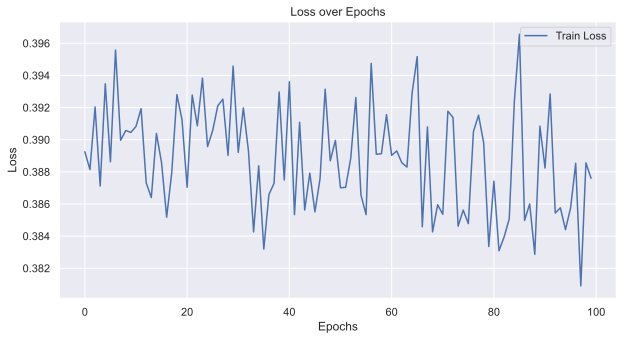

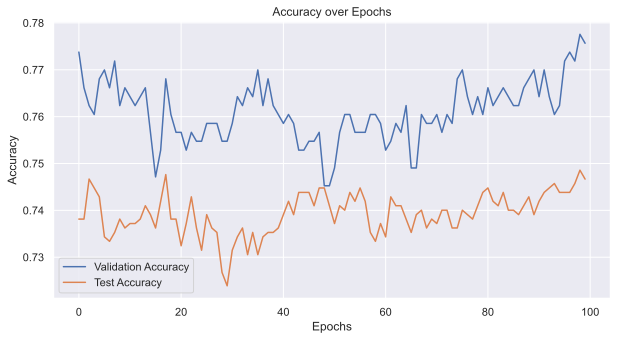

In [30]:
losses = []
val_accuracies = []
test_accuracies = []

# Se utiliza para desactivar el cálculo de gradientes
@torch.no_grad()
def test_accuracy(data):
    # Pone el modelo en modo de evaluación
    model.eval()
    # Calcula las representaciones codificadas de los nodos del grafo utilizando el método encode del modelo.
    z = model.encode(data.x, data.edge_index)
    #Decodifica las representaciones de los nodos para obtener las predicciones del modelo, aplica la función sigmoid para obtener probabilidades y reformatea el tensor resultante.
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    #Decodifica las representaciones de los nodos para obtener las predicciones del modelo, aplica la función sigmoid para obtener probabilidades y reformatea el tensor resultante.
    predictions = (out > 0.5).float() # Convertir probabilidades a etiquetas binarias
    # Calcula el número de predicciones correctas comparando las predicciones con las etiquetas verdaderas.
    correct = (predictions == data.edge_label).float().sum()
    # Calcula la precisión (accuracy) como el número de predicciones correctas dividido por el número total de etiquetas.
    accuracy = correct / len(data.edge_label)
    
    return accuracy.item()

for epoch in range(1, 101):
    loss = train()
    losses.append(loss.item())
    
    val_accuracy_score = test_accuracy(val_data)
    val_accuracies.append(val_accuracy_score)
    
    test_accuracy_score = test_accuracy(test_data)
    test_accuracies.append(test_accuracy_score)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Accuracy: {val_accuracy_score:.4f}, Test Accuracy: {test_accuracy_score:.4f}')



import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(10,5))
plt.plot(losses, label='Train Loss')
plt.title('Loss a lo largo de Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar las precisiones
plt.figure(figsize=(10,5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy a lo largo de Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



### A nivel de grafo (graph-level tasks). Ejemplo: Clasificación de moléculas

Por último, vamos a aplicar las GNN a una clasificación a nivel de grafos. El objetivo es clasificar un grafo entero en lugar de nodos o aristas individuales. Por ejemplo, imaginemos que queremos comparar si una red de recomendaciones es muy parecida a la de otro cliente, para clasificarlos como similares de cara a futuras recomendaciones.

Como ejemplo práctico, vamos a usar un dataset con múltiples grafos que tenemos que clasificar en base a algunas propiedades estructurales del grafo. Lo más típico es la predicción de propiedades moleculares, en la que las moléculas se representan como grafos. Cada átomo está vinculado a un nodo, y las aristas del grafo son los enlaces entre átomos. Podemos ver el ejemplo en la figura:


<center width="100%"><img src="https://phlippe.github.io/post/categorical-nf/molecule_graph.svg" width="600px"></center>

A la izquierda, tenemos una pequeña molécula con diferentes átomos, mientras que la parte derecha de la imagen muestra la representación en forma de grafo. Los tipos de átomo se abstraen como características de nodo (por ejemplo, un vector de un punto), y los diferentes tipos de enlace se utilizan como características de la arista. Por simplicidad,no vamos a tener en cuenta los atributos de las aristas, pero se pueden incluir con métodos como la Convolución Relacional de Grafos (Relational Graph Convolution) que utiliza una matriz de pesos diferente para cada tipo de borde.


El dataset a usar se llama [MUTAG](https://paperswithcode.com/dataset/mutag). Es una colección de compuestos nitroaromáticos y el objetivo es predecir su mutagenicidad en Salmonella typhimurium. Contiene 188 compuestos químicos/grafos con 18 nodos y 20 aristas de media para cada grafo. Los nodos del grafo tienen 7 etiquetas/tipos de átomo diferentes, y las etiquetas binarias del grafo representan "su efecto mutagénico en una bacteria gramnegativa específica".

In [31]:
mutag_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG")

Vemos algunas estadísticas del dataset

In [32]:
print("Formato de los datos:", mutag_dataset.data)
print("Número de grafos:", len(mutag_dataset))
print(f"Etiqueta media: {mutag_dataset.data.y.float().mean().item():4.2f}")

Formato de los datos: Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])
Número de grafos: 188
Etiqueta media: 0.66


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


La primera línea muestra cómo el conjunto de datos almacena los distintos grafos en un tensor, con la concatenación de los nodos, las aristas y las etiquetas de cada grafo, así los índices en los que se dividen los tensores.

La longitud del conjunto de datos es el número de grafos que tenemos, y la "etiqueta media" denota el porcentaje del grafo con etiqueta 1. Mientras el porcentaje esté en el intervalo de 0,5, tendremos un conjunto de datos relativamente equilibrado. Es una práctica muy recomendada, puesto que, a menudo, los conjuntos de datos de grafos están muy desequilibrados.

Ahora vamos a dividir nuestro conjunto de datos en una parte de entrenamiento y otra de prueba. Tenga en cuenta que esta vez no utilizamos un conjunto de validación debido al pequeño tamaño del conjunto de datos. Por lo tanto, nuestro modelo podría sobreajustarse ligeramente en el conjunto de validación debido al ruido de la evaluación, pero aún así obtendremos una estimación del rendimiento en datos no entrenados.

In [41]:
torch.manual_seed(42)
mutag_dataset.shuffle()
train_dataset = mutag_dataset[:150]
test_dataset = mutag_dataset[150:]

Cuando usamos un data loader, nos encontramos con un problema al agrupar $N$ grafos por lotes. Cada grafo del lote puede tener un número diferente de nodos y aristas, por lo que necesitaríamos mucho relleno para obtener un único tensor.

Torch geometric utiliza un enfoque diferente y más eficiente: podemos ver los grafos $N$ de un lote como un único grafo grande con una lista concatenada de nodos y aristas. Como no hay aristas entre los grafos $N$, ejecutar capas GNN en el grafo grande nos da el mismo resultado que ejecutar el GNN en cada grafo por separado (ver imagen abajo).


<center width="100%"><img src="https://theaisummer.com/static/4e7a74f1f1559f684294e111b7742d11/105d8/graph-batching.png" width="600px"></center>

La matriz de adyacencia es cero para los nodos que proceden de dos grafos diferentes y, en caso contrario, según la matriz de adyacencia del grafo individual. Por suerte, esta estrategia ya está implementada en torch geometric, por lo que podemos usar el data loader correspondiente:

In [34]:
graph_train_loader = geom_data.DataLoader(train_dataset, batch_size=64, shuffle=True) #Shuffle = organizar en cada época
graph_val_loader = geom_data.DataLoader(test_dataset, batch_size=64)
graph_test_loader = geom_data.DataLoader(test_dataset, batch_size=64)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Carguemos un lote a continuación para ver la agrupación:

In [35]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Etiquetas:", batch.y[:10])
print("Índices del batch:", batch.batch[:40]) #Visualizamos solo las 40 primeras, para entenderlo...

Batch: DataBatch(edge_index=[2, 1512], x=[687, 7], edge_attr=[1512, 4], y=[38], batch=[687], ptr=[39])
Etiquetas: tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0])
Índices del batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])


Tenemos 38 grafos agrupados juntos para el conjunto de datos de test. Los índices de lote, almacenados en `batch`, muestran que los 12 primeros nodos pertenecen al primer grafo, los 22 siguientes al segundo, y así sucesivamente. Estos índices son importantes para realizar la predicción final. Para realizar una predicción sobre un grafo completo, normalmente realizamos una operación de agrupación sobre todos los nodos después de ejecutar el modelo GNN. En este caso, utilizaremos el average pooling. Por lo tanto, necesitamos saber qué nodos deben incluirse en cada average pool. Usando este pooling, ya podemos crear nuestra red de abajo. Concretamente, reutilizamos nuestra clase `GNNModel` de antes, y simplemente añadimos un average pooling y una única capa lineal para la tarea de predicción de grafos.

In [36]:
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Entradas:
            c_in - Dimensionalidad de las características de entrada
            c_hidden - Dimensionalidad de las características de la oculta
            c_out - Dimensionalidad de las características de entrada (normalmente el número de clases)
            dp_rate_linear - La tasa de dropout antes de la capa lineal (normalmente mucho mayor que dentro de la GNN)
            kwargs - Argumentos adicionales para la GNN
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in,
                            c_hidden=c_hidden,
                            c_out=c_hidden, #No sería la predicción final todavia
                            **kwargs)
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Entradas:
            x - Características de entrada por nodo
            edge_index - Lista de índices de los nodos que estan conectados por aristas en el grafo (notación de PyTorch geometric)
            batch_idx - Índice del lote para cada nodo
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
        x = self.head(x)
        return x

Por último, podemos crear un módulo PyTorch Lightning para manejar el entrenamiento, como ya explicamos antes. Como tenemos una tarea de clasificación binaria, usamos la función de pérdida Binary Cross Entropy.

In [37]:
class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Guardando los hiperparámetros
        self.save_hyperparameters()

        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss() #Función de pérdida

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)
        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.0) #Se pone una tasa de aprendizaje (lr) alto porque el dataset es pequeño (y el modelo)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)

A continuación entrenamos el modelo en nuestro conjunto de datos. Se parece a las funciones de entrenamiento típicas que hemos visto hasta ahora.

In [38]:
def train_graph_classifier(model_name, **model_kwargs):
    pl.seed_everything(42)

    #Creamos el módulo PyTorch Lightning para entrenamiento con retorno
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=500,
                         enable_progress_bar=False)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    #Comprobamos si existe ya el modelo preentrenado, y lo cargamos si es así
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Encontrado un modelo preentrenado, cargando...")
        model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=mutag_dataset.num_node_features,
                              c_out=1 if mutag_dataset.num_classes==2 else mutag_dataset.num_classes,
                              **model_kwargs)
        trainer.fit(model, graph_train_loader, graph_val_loader)
        model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    #Obtenemos el mejor modelo de test en los conjuntos de validación y de test
    train_result = trainer.test(model, graph_train_loader, verbose=False)
    test_result = trainer.test(model, graph_test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']}
    return model, result

Por último, vamos a realizar el entrenamiento y las pruebas.

In [39]:
model, result = train_graph_classifier(model_name="GraphConv",
                                       c_hidden=256,
                                       layer_name="GraphConv",
                                       num_layers=3,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Global seed set to 42

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GraphGNNModel     | 266 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.067     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, v

In [40]:
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")

Train performance: 92.76%
Test performance:  92.11%


**Pregunta 5:** ¿Hay overfitting?

**Respuesta Pregunta 5**

Rendimiento en el Conjunto de Entrenamiento (Train performance): 92.76%

Rendimiento en el Conjunto de Prueba (Test performance): 92.11%

Dado que el rendimiento en el conjunto de entrenamiento y en el conjunto de prueba son muy similares y ambos son altos, no hay evidencia significativa de overfitting en este modelo.


**Ejercicio 6:** "Trastear" con diferentes capas GNN, hiperparámetros, etc.

In [46]:
model, result = train_graph_classifier(model_name="GraphConv",
                                       c_hidden=128,
                                       num_layers=2,
                                       dp_rate_linear=0.3,
                                       dp_rate=0.1,
                                       layer_name="GraphConv",
                                       lr=0.01,
                                       weight_decay=0.001)
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GraphGNNModel     | 34.9 K
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
34.9 K    Trainable params
0         Non-trainable params
34.9 K    Total params
0.140     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=500` reached.


Train performance: 88.73%
Test performance:  89.47%


In [50]:
model, result = train_graph_classifier(model_name="GraphConv",
                                       c_hidden=128, # Cambiar el número de unidades ocultas
                                       layer_name="GraphConv",
                                       num_layers=10, # Cambiar el número de capas
                                       dp_rate=0.1, # Ajustar la tasa de dropout en la GNN
                                       lr=0.01, # Ajustar la tasa de aprendizaje
                                       weight_decay=0.001) # Ajustar el weight decay
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")


Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GraphGNNModel     | 298 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
298 K     Trainable params
0         Non-trainable params
298 K     Total params
1.192     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=500` reached.


Train performance: 89.20%
Test performance:  86.84%


## Conclusiones

Hemos visto la aplicación de las redes neuronales a las estructuras de grafos. Hemos visto cómo se puede representar un grafo (matriz de adyacencia o lista de aristas), y hemos discutido la implementación de capas de grafos comunes: GCN y GAT. Las implementaciones mostraron el lado práctico de las capas, que a menudo es más sencillo que la teoría. Por último, experimentamos con distintas tareas a nivel de nodos, aristas y grafos. En general, hemos visto que incluir información sobre grafos en las predicciones puede ser crucial para lograr un alto rendimiento. Hay muchas aplicaciones que se benefician de las GNN, y es probable que la importancia de estas redes aumente en los próximos años.

**Ejercicio 7:** Tal y como entiendes inicialmente el concepto de razonamiento computacional bajo incertidumbre, por algún ejemplo de problema real con las GNNs que necesitaría tratar la incertidumbre.

**Respuesta ejercicio 7**
Un ejemplo real donde las GNNs podrían necesitar tratar con incertidumbre es en la predicción de interacciones proteína-proteína. Las proteínas interactúan entre sí en una célula para llevar a cabo diversas funciones biológicas, y predecir estas interacciones es crucial para entender los procesos biológicos y desarrollar terapias para enfermedades. 
(Esto me lo ha explicado mi vecina que trabaja en un laboratorio y no se si realmente sería aplicable con GNNs)
Pero se podría desarrollar una GNN que tome en cuenta la incertidumbre en la estructura del grafo y en las características de los nodos.